# PSO para otimizar pesos de MLP 

In [1]:
using Distributions
using CSV
using Plots
using DataFrames

### MLP

In [2]:
function init_params(n_in::Int64, n_h::Int64)
    W1 = rand(Uniform(-1/sqrt(n_h+n_in),1/sqrt(n_h+n_in)),n_h, n_in)
    b1 = rand(Uniform(-1/sqrt(n_h),1/sqrt(n_h)),n_h)
    W2 = rand(Uniform(-1/sqrt(1+n_h),1/sqrt(1+n_h)), 1, n_h)
    b2 = rand(Uniform(-1,1), 1, 1)
    return [W1, b1, W2, b2]
end

function forward_prop(x, params)
    W1 = params[1]
    b1 = params[2]
    W2 = params[3]
    b2 = params[4]
    
    linear1 = W1 * x .+ b1
    linear2 = W2 * linear1 .+ b2
    out = 1.7159*tanh.(2/3*linear2)
    
    return out
end

function compute_cost(A2, y)
    m = size(y)[2]
    erro = A2 .- y
    cost = 1/m * sum(erro.^2)
    return cost
end

function params_array(params)
    W1 = parametros[1]
    b1 = parametros[2]
    W2 = parametros[3]
    b2 = parametros[4]
    lista_params = hcat(reshape(W1, 1,prod(size(W1))), reshape(b1, 1,prod(size(b1))), 
        reshape(W2, 1,prod(size(W2))), reshape(b2, 1,prod(size(b2))))
    return lista_params
end

function params_reshape(lista_params, params)
    W1 = params[1]
    b1 = params[2]
    W2 = params[3]
    b2 = params[4]

    w1_dim_tot = prod(size(W1))
    b1_dim_tot = prod(size(b1))
    w2_dim_tot = prod(size(W2))
    b2_dim_tot = prod(size(b2))

    W1_reshaped = reshape(lista_params[1:w1_dim_tot], size(W1))
    id = w1_dim_tot
    b1_reshaped = reshape(lista_params[id+1:id+b1_dim_tot], size(b1))
    id += b1_dim_tot
    W2_reshaped = reshape(lista_params[id+1:id+w2_dim_tot], size(W2))
    id += w2_dim_tot
    b2_reshaped = reshape(lista_params[id+1:id+b2_dim_tot], size(b2))
    
    return [W1_reshaped, b1_reshaped, W2_reshaped, b2_reshaped]
    
end
    

params_reshape (generic function with 1 method)

### Importar dados

In [3]:
sunspot = CSV.read("dados/sunspot.csv"; delim=",");

┌ Warning: `CSV.read(input; kw...)` is deprecated in favor of `using DataFrames; CSV.read(input, DataFrame; kw...)
│   caller = ip:0x0
└ @ Core :-1


In [4]:
sunspot_serie = sunspot["valor"];

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[4]:1
└ @ Core In[4]:1


In [5]:
sunspot_serie[1:10]

10-element Array{Float64,1}:
  5.0
 11.0
 16.0
 23.0
 36.0
 58.0
 29.0
 20.0
 10.0
  8.0

### Funções de normalização

In [6]:
# normalizar serie
function normalizar(serie)
    max = maximum(serie)
    min = minimum(serie)
    
    y_temp = 2 .* ((serie .- min)) / (max .- min) .- 1
    
    y = y_temp ./ sqrt(size(serie)[1])
    
    return y
end

function desnormalizar(serie_norm, serie)
    max = maximum(serie)
    min = maximum(serie)
    
    serie_temp = serie_norm * sqrt(size(serie)[1])
    serie_temp2 = (serie_temp .+ 1)/2
    serie_temp3 = serie_temp2 * ((max - min) + min)
    return serie_temp3 
end

desnormalizar (generic function with 1 method)

In [7]:
serie_norm = normalizar(sunspot_serie)
se = desnormalizar(serie_norm, sunspot_serie);

### Função de dividir os dados em X e Y

In [8]:
function split_sequence(serie, n_steps_in::Int64)
    len = size(serie)[1]
    max_iter = len - n_steps_in
    seq_x = zeros(max_iter, n_steps_in)
    seq_y = zeros(max_iter)
    for i in 1:len-n_steps_in
        idx = i + n_steps_in - 1
        out_idx = idx + 1
        if out_idx > len
            println(i)
            println("len = ", len)
            println("out_idx = ", out_idx)
            println("Out_idx > len")
            break
        end
        seq_x[i,:] = serie[i:idx]
        seq_y[i] = serie[out_idx]
    end
    return seq_x, seq_y
end

split_sequence (generic function with 1 method)

In [9]:
X, y = split_sequence(serie_norm, 10);

### Função de split treino/val/teste

In [10]:
function divisao_dados_temporais(X, y, perc_treino::Float64, perc_val::Float64)
    tam_treino = convert(Int64, floor(perc_treino * size(y)[1]))
    
    if perc_val > 0
        tam_val = convert(Int64, floor(perc_val * size(y)[1]))
        X_treino = X[1:tam_treino,:]
        y_treino = y[1:tam_treino]
        
        X_val = X[tam_treino+1:tam_treino+1+tam_val,:]
        y_val = y[tam_treino+1:tam_treino+1+tam_val]
        
        X_teste = X[(tam_treino+tam_val+1):end,:]
        y_teste = y[(tam_treino+tam_val+1):end]
        
        return X_treino, y_treino, X_teste, y_teste,  X_val, y_val
        
    else
        X_treino = X[1:tam_treino,:]
        y_treino = y[1:tam_treino]
        
        X_teste = X[tam_treino+1:end,:]
        y_teste = y[tam_treino+1:end]
        return X_treino, y_treino, X_teste, y_teste
    end
end

divisao_dados_temporais (generic function with 1 method)

### Função do PSO

In [11]:
function PSO(X, y, params, n_particles::Int64, dim, max_iter::Int64, LB::Float64, UB::Float64, perc_treino::Float64, perc_val::Float64)
    
    mse_treino = zeros(0)
    mse_val = zeros(0)
    mse_teste = zeros(0)
    
    particles = rand(n_particles, sum(dim))
    velocity = zeros(n_particles, sum(dim))
    pbest = particles
    gbest = pbest[1,:]
    
    parametros = params_reshape(gbest, params)
    y_pred = forward_prop(X[:,:,1]', parametros)
    gbest_value = compute_cost(y_pred, y[:,1]')    

    fitness_value = zeros(n_particles)

    for i in eachindex(fitness_value)
        parametros = params_reshape(particles[i,:], params)
        y_pred = forward_prop(X[:,:,1]', parametros)
        fitness_value[i] = compute_cost(y_pred, y[:,1]')
    end
    
    wmax = 0.9
    wmin = 0.4
    c1 = 1.5
    c2 = 1.5
    for janela in 1:size(y)[2]
        
        X_treino, Y_treino, X_teste, Y_teste, X_val, Y_val = divisao_dados_temporais(X[:,:,janela], y[:,janela], perc_treino, perc_val)
        
        X_tv = vcat(X_treino, X_val)'
        Y_tv = vcat(Y_treino, Y_val)'

        for k in 1:max_iter
            w=wmax-(wmax-wmin)*k/max_iter
        

            for i in 1:n_particles
                for j in 1:sum(dim)
                    velocity[i, j] = w*velocity[i,j] + c1*rand()*(pbest[i,j] - particles[i,j]) + c2*rand()*(gbest[j] - particles[i,j])
                end
            end

            # update pso position
            for i in 1:n_particles
                for j in 1:sum(dim)
                    particles[i,j] = particles[i,j] + velocity[i,j]
                end
            end

            # handling boundary violations 
            for i in 1:n_particles
                for j in 1:sum(dim)
                    if particles[i,j]<LB 
                        particles[i,j]=LB 
                    elseif particles[i,j]>UB 
                        particles[i,j]=UB 
                    end
                end 
            end 

            # evaluating fitness
            for i in 1:n_particles
                parametros = params_reshape(particles[i,:], params)
                y_pred = forward_prop(X_treino', parametros)
                fitness_value[i] = compute_cost(y_pred, Y_treino')
            end

            # updating pbest and fitness
            for i in 1:n_particles
                parametros_pbest = params_reshape(pbest[i, :], params)
                y_pred_pbest = forward_prop(X_treino', parametros_pbest)
                if fitness_value[i] < compute_cost(y_pred_pbest, Y_treino')
                    pbest[i] = particles[i, :]
                end
            end

            # updating gbest 
            for i in 1:n_particles    
                if fitness_value[i] < gbest_value
                    gbest_value = fitness_value[i]
                    gbest = particles[i,:]   
                end
            end
    
            parametros_gbest = params_reshape(gbest, params)
            # treino e validacao mse
            A2_gbest_tv = forward_prop(X_tv, parametros_gbest)
            mse_tv = compute_cost(A2_gbest_tv, Y_tv)
            append!(mse_treino,mse_tv)

            # validacao mse
            A2_gbest_v = forward_prop(X_val', parametros_gbest)
            mse_v = compute_cost(A2_gbest_v, Y_val')
            append!(mse_val,mse_v)

            # teste
            A2_gbest_t = forward_prop(X_teste', parametros_gbest)
            mse_t = compute_cost(A2_gbest_t, Y_teste')
            append!(mse_teste,mse_t)
        end
    end
    return mse_treino, mse_val, mse_teste
end

PSO (generic function with 1 method)

In [12]:
function n_model_pso(X, y, n_h::Int64, num_iteracoes::Int64, perc_treino::Float64, perc_val::Float64)
    n_in = size(X)[2]
    parametros = init_params(n_in, n_h)
    
#     A2 = forward_prop(X', parametros)

#     best_cost = compute_cost(A2, y')
    
    W1 = parametros[1]
    b1 = parametros[2]
    W2 = parametros[3]
    b2 = parametros[4]
    
    dim_list = [prod(size(W1)), prod(size(b1)), prod(size(W2)), prod(size(b2))]

    mse_treino, mse_val, mse_teste = PSO(X, y, parametros, 10, dim_list, num_iteracoes, -1.0, 1.0, perc_treino, perc_val)
        
    return mse_treino, mse_val, mse_teste
end

n_model_pso (generic function with 1 method)

### Função para criar os cenários dinâmicos

In [13]:
# janelamento para cenários dinâmicos
function cenarios_dinamicos(serie, window_size::Int64, step_size::Int64)
    
    if ndims(serie) == 1
        w = window_size
        s = step_size
        t = size(serie)[1]

        i_max = convert(Int64,floor((t-w)/s))

        s_temp = serie[(1*s):((1*s)+w-1)]

        cenarios = zeros(0)

        append!(cenarios, s_temp)

        for i in 2:i_max
            s_temp = serie[(i*s):((i*s)+w-1)]
            cenarios = hcat(cenarios, s_temp)
        end
        return cenarios
    else
        w = window_size
        s = step_size
        t = size(serie)[1]

        i_max = convert(Int64,floor((t-w)/s))

        s_temp = serie[(1*s):((1*s)+w-1), :]

        cenarios = zeros(w, size(X)[2], i_max)

        cenarios[:,:, 1] = s_temp

        for i in 2:i_max
            s_temp = serie[(i*s):((i*s)+w-1),:]
            cenarios[:, :, i] = s_temp
        end
        return cenarios
    end
end

cenarios_dinamicos (generic function with 1 method)

### Função para executar os cenários dinâmicos

In [14]:
# Criando cenários
function cenarios_execucoes(X, y, w, s, f::Int64, perc_treino::Float64, perc_val::Float64,qtd_execucoes::Int64)
    
    # gerando os cenários dinâmicos
    X_I = cenarios_dinamicos(X, w, s)
    y_I = cenarios_dinamicos(y, w, s)
 
    # calculando a quantidade de iterações
    T = convert(Int64,floor(f/s*(size(y)[1]-w)+f))

    println("Quantidade de iterações: ", T)
    
    neuronios = 2:25
    
    mse_treino = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_val = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
    mse_teste = zeros(qtd_execucoes, size(neuronios)[1], size(y_I)[2] * f)
 
    execucoes = 1:qtd_execucoes

    for execucao in eachindex(execucoes)

        println("Execução: ", execucao)
        
        # Neuronios
        for (j,z) in zip(neuronios, eachindex(neuronios))
            
            mse_treino_lista_temp, mse_val_lista_temp, mse_teste_lista_temp = n_model_pso(X_I, y_I, j, f, perc_treino, perc_val)

            # salvar lista com os mse de treino para todas as iterações
            mse_treino[execucao, z,:] = mse_treino_lista_temp
            # salvar lista com os mse de validacao para todas as iteracoes
            mse_val[execucao, z,:] = mse_val_lista_temp
            # salvar lista com os mse de teste para todas as iterações
            mse_teste[execucao, z,:] = mse_teste_lista_temp

        end
    end
    return mse_treino, mse_val, mse_teste
end
            

cenarios_execucoes (generic function with 1 method)

In [ ]:
w = 60
s = 10
f = 50

In [18]:
@time mse_treino, mse_val, mse_teste = cenarios_execucoes(X, y, w, s, f, 0.54, 0.24, 30);

Quantidade de iterações: 1145
Execução: 1
Execução: 2
Execução: 3
Execução: 4
Execução: 5
Execução: 6
Execução: 7
Execução: 8
Execução: 9
Execução: 10
Execução: 11
Execução: 12
Execução: 13
Execução: 14
Execução: 15
Execução: 16
Execução: 17
Execução: 18
Execução: 19
Execução: 20
Execução: 21
Execução: 22
Execução: 23
Execução: 24
Execução: 25
Execução: 26
Execução: 27
Execução: 28
Execução: 29
Execução: 30
601.397508 seconds (1.13 G allocations: 234.304 GiB, 3.72% gc time)


In [ ]:
methods(n_model_pso)

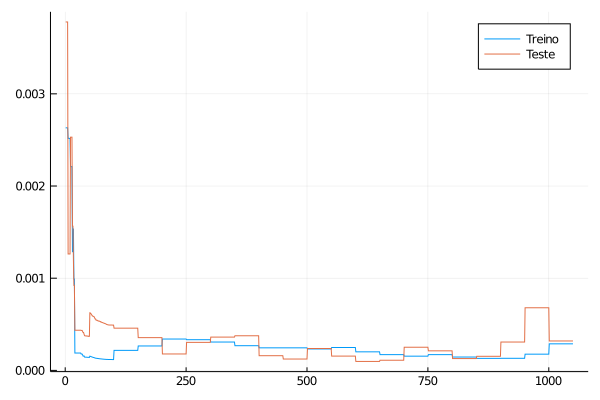

In [47]:
plot(mse_treino[1,2,:], label = "Treino")
plot!(mse_teste[1,2,:], label = "Teste")

## HIT
### Hourly internet traffic time series (HIT)

* 1657 obs.
* hourly 
* 19 nov 2004 at 9:30 and 27 jan 2005 at 11:11

Série horária: 24 inputs


In [51]:
hit = CSV.read("dados/internet_traffic.csv"; delim=",")
hit = hit["valor"]

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[51]:2
└ @ Core In[51]:2


19888-element Array{Float64,1}:
 4838.6653764143
 4845.17660886383
 5157.99566038366
 5637.87553691444
 5520.68984027836
 5626.3374553168
 5350.54601579701
 5356.98340890114
 5385.81381165372
 5403.90580523122
 5666.34777146069
 5764.14155813563
 5902.47446148357
    ⋮
 5924.1760746544
 6038.8308550728
 6140.9858667152
 6191.9407441848
 6243.312822492
 6304.9263254312
 6438.785759172
 6515.5123373656
 6291.1709745264
 6305.5185238856
 6422.143533156
 6511.0139275416

In [104]:
qtd_inputs = 24
hit_norm = normalizar(hit)
global X, y = split_sequence(hit_norm, 24);

In [102]:
w = 584 # tamanho da janela
s = 100 # tamanho do passo
f = 50 # quantidade de iterações para a janela
T = convert(Int64,floor(f/s*(size(hit)[1]-w)+f))
println(T)
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

9702


192

In [103]:
@time hit_mse_treino_1, hit_mse_val, hit_mse_teste = cenarios_execucoes(X, y, w, s, f, 0.54, 0.24, 3);

Quantidade de iterações: 9690
Execução: 1


InterruptException: InterruptException:

In [117]:
CSV.write("hit_mse_treino_1_exec_1.csv", DataFrame(hit_mse_treino_1[1,:,:]))
CSV.write("hit_mse_treino_1_exec_2.csv", DataFrame(hit_mse_treino_1[2,:,:]))
CSV.write("hit_mse_treino_1_exec_3.csv", DataFrame(hit_mse_treino_1[3,:,:]))
CSV.write("hit_mse_val_1_exec_1.csv", DataFrame(hit_mse_val[1,:,:]))
CSV.write("hit_mse_val_1_exec_2.csv", DataFrame(hit_mse_val[2,:,:]))
CSV.write("hit_mse_val_1_exec_3.csv", DataFrame(hit_mse_val[3,:,:]))
CSV.write("hit_mse_teste_1_exec_1.csv", DataFrame(hit_mse_teste[1,:,:]))
CSV.write("hit_mse_teste_1_exec_2.csv", DataFrame(hit_mse_teste[2,:,:]))
CSV.write("hit_mse_teste_1_exec_3.csv", DataFrame(hit_mse_teste[3,:,:]))

"hit_mse_teste_1_exec_3.csv"

### Cenário 2


In [105]:
w = 584 # tamanho da janela
s = 250 # tamanho do passo
f = 100 # quantidade de iterações para a janela
T = convert(Int64, floor(f/s*(size(hit)[1]-w)+f))
print(T)
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

7821

77

In [106]:
@time hit_mse_treino_2, hit_mse_val_2, hit_mse_teste_2 = cenarios_execucoes(X, y, w, s, f, 0.54, 0.24, 3);

Quantidade de iterações: 7812
Execução: 1
Execução: 2
Execução: 3
770.169006 seconds (869.09 M allocations: 1.073 TiB, 3.30% gc time)


In [114]:
CSV.write("hit_mse_treino_2_exec_1.csv", DataFrame(hit_mse_treino_2[1,:,:]))
CSV.write("hit_mse_treino_2_exec_2.csv", DataFrame(hit_mse_treino_2[2,:,:]))
CSV.write("hit_mse_treino_2_exec_3.csv", DataFrame(hit_mse_treino_2[3,:,:]))
CSV.write("hit_mse_val_2_exec_1.csv", DataFrame(hit_mse_val_2[1,:,:]))
CSV.write("hit_mse_val_2_exec_2.csv", DataFrame(hit_mse_val_2[2,:,:]))
CSV.write("hit_mse_val_2_exec_3.csv", DataFrame(hit_mse_val_2[3,:,:]))
CSV.write("hit_mse_teste_2_exec_1.csv", DataFrame(hit_mse_teste_2[1,:,:]))
CSV.write("hit_mse_teste_2_exec_2.csv", DataFrame(hit_mse_teste_2[2,:,:]))
CSV.write("hit_mse_teste_2_exec_3.csv", DataFrame(hit_mse_teste_2[3,:,:]))

"hit_mse_teste_2_exec_3.csv"

## Cenário III

* w = 584
* s = 500
* f = 150


In [108]:
w = 584 # tamanho da janela
s = 500 # tamanho do passo
f = 150 # quantidade de iterações para a janela
T = convert(Int64, floor(f/s*(size(hit)[1]-w)+f))
print(T)
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

5941

38

In [109]:
@time hit_mse_treino_3, hit_mse_val_3, hit_mse_teste_3 = cenarios_execucoes(X, y, w, s, f, 0.54, 0.24, 3);

Quantidade de iterações: 5934
Execução: 1
Execução: 2
Execução: 3
586.274432 seconds (643.36 M allocations: 812.641 GiB, 3.80% gc time)


In [115]:
CSV.write("hit_mse_treino_3_exec_1.csv", DataFrame(hit_mse_treino_3[1,:,:]))
CSV.write("hit_mse_treino_3_exec_2.csv", DataFrame(hit_mse_treino_3[2,:,:]))
CSV.write("hit_mse_treino_3_exec_3.csv", DataFrame(hit_mse_treino_3[3,:,:]))
CSV.write("hit_mse_val_3_exec_1.csv", DataFrame(hit_mse_val_3[1,:,:]))
CSV.write("hit_mse_val_3_exec_2.csv", DataFrame(hit_mse_val_3[2,:,:]))
CSV.write("hit_mse_val_3_exec_3.csv", DataFrame(hit_mse_val_3[3,:,:]))
CSV.write("hit_mse_teste_3_exec_1.csv", DataFrame(hit_mse_teste_3[1,:,:]))
CSV.write("hit_mse_teste_3_exec_2.csv", DataFrame(hit_mse_teste_3[2,:,:]))
CSV.write("hit_mse_teste_3_exec_3.csv", DataFrame(hit_mse_teste_3[3,:,:]))

"hit_mse_teste_3_exec_3.csv"

## Cenário IV

* w = 584
* s = 584
* f = 100



In [111]:
w = 584 # tamanho da janela
s = 584 # tamanho do passo
f = 100 # quantidade de iterações para a janela
T = convert(Int64, floor(f/s*(size(hit)[1]-w)+f))
print(T)
quantidade_janelas = convert(Int64,floor((size(y)[1] - w)/s))

3405

33

In [112]:
@time hit_mse_treino_4, hit_mse_val_4, hit_mse_teste_4 = cenarios_execucoes(X, y, w, s, f, 0.54, 0.24, 3);

Quantidade de iterações: 3401
Execução: 1
Execução: 2
Execução: 3
364.386484 seconds (372.58 M allocations: 470.898 GiB, 9.65% gc time)


In [116]:
CSV.write("hit_mse_treino_4_exec_1.csv", DataFrame(hit_mse_treino_4[1,:,:]))
CSV.write("hit_mse_treino_4_exec_2.csv", DataFrame(hit_mse_treino_4[2,:,:]))
CSV.write("hit_mse_treino_4_exec_3.csv", DataFrame(hit_mse_treino_4[3,:,:]))
CSV.write("hit_mse_val_4_exec_1.csv", DataFrame(hit_mse_val_4[1,:,:]))
CSV.write("hit_mse_val_4_exec_2.csv", DataFrame(hit_mse_val_4[2,:,:]))
CSV.write("hit_mse_val_4_exec_3.csv", DataFrame(hit_mse_val_4[3,:,:]))
CSV.write("hit_mse_teste_4_exec_1.csv", DataFrame(hit_mse_teste_4[1,:,:]))
CSV.write("hit_mse_teste_4_exec_2.csv", DataFrame(hit_mse_teste_4[2,:,:]))
CSV.write("hit_mse_teste_4_exec_3.csv", DataFrame(hit_mse_teste_4[3,:,:]))

"hit_mse_teste_4_exec_3.csv"